First the required packages are installed. Numpy allows for large array and matrix operations. Matplotlib is used for plotting the required figures. Cv2 is an open computer vision library, os is used for interacting with the operating system and random is used when randomly shuffling our data. Tqdm is used to show progress bars when iterating. Then we import the relevant literature from keras. Sequential is the model used for stacking layers. Dense, Dropout, Activation and flatten are core layers imported from keras. Finally, Conv2D and MaxPooling2D are keras layers used in CNNs:

In [4]:

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tqdm import tqdm
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

print(tf.__version__)

2.1.0


Here we set the working directory and define the datasets. The data is already split into training and testing sets. The image size is also fixed to 50 for later use:

In [5]:
#CATS V DOGS:

DATADIR = r"C:\Users\theod\Desktop\2K19-20 Modules\Deep Learning\dl-medical-imaging\malaria2"
#setting directory
CATEGORIES_TRAINING = ["Infected_train", "Uninfected_train"]
CATEGORIES_TESTING = ["Infected_test", "Uninfected_test"]

#adjusting image size
IMG_SIZE =50

The training set is created by appending our empty list in an iterative manner. Progress bars show that the two subsets of the training set (Infected and Uninfected) including the same number of images are complete:

In [6]:
#creating training data
training_data = []
def create_training_data():
    for category in CATEGORIES_TRAINING:  # do infected & uninfected

        path = os.path.join(DATADIR,category)  # create path to infected & uninfected
        class_num = CATEGORIES_TRAINING.index(category)  # get the classification  (0 or a 1). 0=Infected 1=Uninfected

        for img in tqdm(os.listdir(path)):  # iterate over each image per infected & uninfected
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  #append the array
            except Exception as e: 
                pass
          
create_training_data()
#randomly shuffling the training data           


100%|██████████| 9887/9887 [00:14<00:00, 678.90it/s]


The training data is randomly shuffled in order to prevent overfitting (prevent the model from learning that the first 50% of the dataset will always be uninfected). Next, two distinct arrays are created, with to pixel arrays and  corresponding labels:

In [7]:
random.shuffle(training_data)
for sample in training_data[:20]:
    print(sample[1])
print(len(training_data))

x_train = []
y_train = []

for features,label in training_data:
    x_train.append(features)
    y_train.append(label)
x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

0
0
1
0
0
1
0
0
0
1
1
0
1
1
1
0
1
1
0
1
19774


We repeat exactly the same process for the test data, appending in an iterative manner and then randomly shuffling:

In [8]:
#Do the same for test data  
test_data = []
def create_test_data():
    for category in CATEGORIES_TESTING:  # do infected & uninfected

        path = os.path.join(DATADIR,category)  # create path to infected & uninfected
        class_num = CATEGORIES_TESTING.index(category)  # get the classification  (0 or a 1). 0=Infected 1=Uninfected

        for img in tqdm(os.listdir(path)):  # iterate over each image per infected & uninfected
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                test_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_test_data()
random.shuffle(test_data)

print(len(test_data))
x_test = []
y_test = []
for sample in test_data[:20]:
    print(sample[1])
for features,label in test_data:
    x_test.append(features)
    y_test.append(label)


x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

100%|██████████| 2786/2786 [00:11<00:00, 237.52it/s]

5512
1
0
1
1
1
1
0
0
0
1
1
1
1
1
1
0
1
1
0
0


We normalize our data. Most of the time coloured images range from 0 pixels (black) to 255 pixels (white). We rescale by dividing each image by 255 in order to get values between 0 and 1. This simplifies the process:

In [9]:
x_train = x_train/255
x_test = x_test/255

Here we construct the convolutional neural network that will be used for the training phase. The CNN consists of two convolutional layers that use a ReLU as an activation function. Each convolutional layer is followed by a max pooling layer. Finally, the CNN uses a fully connected layer with a ReLU activation before returning the outputs through a softmax function:

In [10]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

We run the model usinf 30% of the training data for validation. We iterate 3 times, with a cumulative running time of approximately 27 minutes. With each iteration we can see the mimisation of the loss function Finally we achieve approximately 93% of both training and validation accuracy:

In [11]:
model.fit(x_train, y_train, batch_size=32, epochs=3, validation_split=0.3)

Train on 13841 samples, validate on 5933 samples
Epoch 1/3
13841/13841 [==============================] - 629s 45ms/sample - loss: 0.6702 - accuracy: 0.5875 - val_loss: 0.6316 - val_accuracy: 0.6300
Epoch 2/3
13841/13841 [==============================] - 532s 38ms/sample - loss: 0.4171 - accuracy: 0.8046 - val_loss: 0.2197 - val_accuracy: 0.9236
Epoch 3/3
13841/13841 [==============================] - 440s 32ms/sample - loss: 0.1908 - accuracy: 0.9301 - val_loss: 0.1848 - val_accuracy: 0.9346


Here we evaluate the accuracy on unseen images, i.e. test dataset. The corresponding test accuracy is 94%:

In [12]:
class_names = ['Infected','Uninfected']



test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc) #Comparing loss and accuracy

5512/5512 - 41s - loss: 0.1574 - accuracy: 0.9425

Test accuracy: 0.9424891


Now that the training phase is complete we can use the built in softmax layer to return predictions for test images as probability arrays (2 elemets, each representing the probability of an image belonging to one of the two classes). We print the predictions for the second test image, together with the class it belongs to:

In [13]:
probability_model = tf.keras.Sequential([model, 
                                        tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

print(predictions[1])#Shows array of probabilites 
print(np.argmax(predictions[1]))

[0.72336704 0.27663305]
0


Finally we define two function that can plot the above results. We want the function to plot colour bars for each probability, together with both the predicted and original label. The first function is used for plotting images tohether with the corresponding labels while the second one plots the bar charts. The label in the bracket is the true label. If the predicted label is not the same then both the labels and charts are highlited red.

In [14]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array), #100%
                                class_names[true_label]),
                                color=color)


In [15]:
x_test = x_test.reshape(5512,50,50)    #add an extra dimension

In [16]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Finally, we plot some results, getting the required outcome:

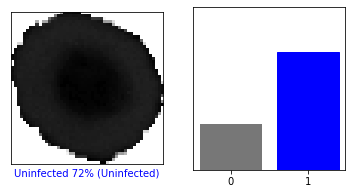

In [17]:
i = 0 #0th image, correect prediction is blue, incoreect is red
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()


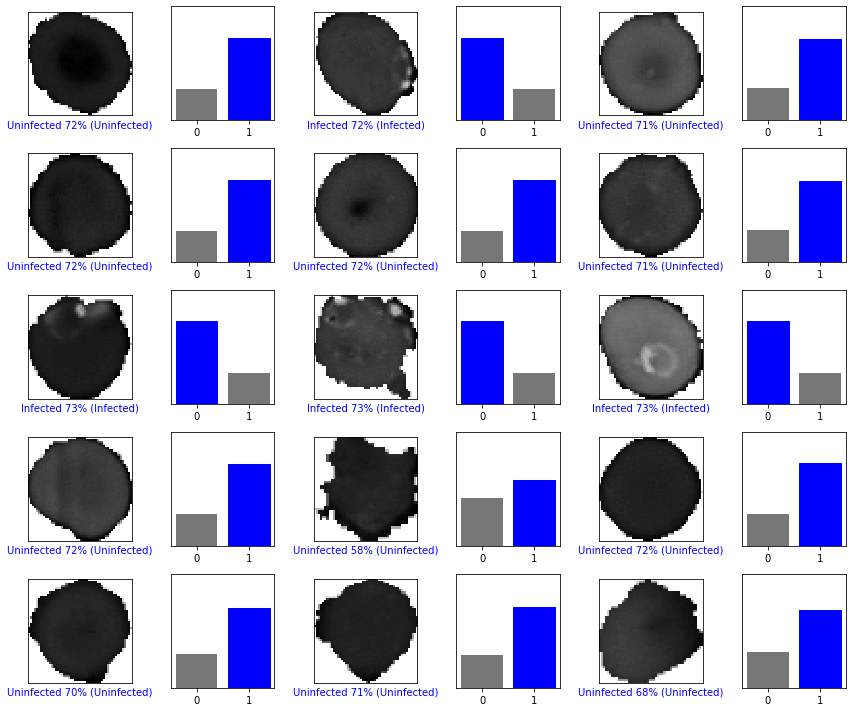

In [18]:
#Predictions for the first 15 images:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

We notice that all of the predictions for the first 15 images are correct with an average confidence slightly over 70%.